<h1 style="font-size:300%">Pokemon classification with a Support Vector Machine</h1>

BSHT Michielsen MSc

This notebook demonstrates how to use a Support Vector Machine (SVM) for image classification. Image recognition is the ability for the computer to identify an object in the image based on the visual characteristics of that object. This is a classification problem, where each possible object is a class, and the provided image should lead to 1 specific class with a as high as feasible certainty. In order to train a classification model with this, a large number of images of the same object are needed. Relative to this notebook there should be a folder named `data` in which several Pokemon images are found. These images are a subset of the [Pokemon collection by Lance Zhang](https://www.kaggle.com/datasets/lantian773030/pokemonclassification) which were picked for the fact that the selected Pokemon have strikingly different colors and therefore the machine can hopefully distinguish them fairly well. More images for the same Pokemon or even different Pokemon can be downloaded and added to the data folder.

First, the versions of the required libraries are shown. It always wise to report the versions of the libraries used so that in case problems arise in the future, one can still go back to a state in which the notebook worked.

In [13]:
import copy, pathlib, math
import PIL.Image as Image

import sklearn
import numpy
import matplotlib
import matplotlib.pyplot as plt

print("scikit-learn version:", sklearn.__version__)     # 1.1.3
print("numpy version:", numpy.__version__)              # 1.23.4
print("matplotlib version:", matplotlib.__version__)    # 3.6.2

scikit-learn version: 1.0.2
numpy version: 1.21.5
matplotlib version: 3.5.2


# 📦 Data provisioning
In real life the data provisioning phase is likely to include more steps about data sourcing and data quality, however for demo purposes in this notebook it is restricted to merely loading the images from the `data` folder, without any concern over quantity nor quality.

The code below will load the images and understand that the subfolder names are the class labels. It is important that all the images are the same size (and in this case square as well) so this code will automatically resize them. If high resolution images are available the `size` parameter can be increased and it will probably improve the performance slightly, at significantly increased training time. The given size of 256 is a middle way which is supposed to give fair results at a reasonable training time.

In [28]:
size = 256

def load_image(file, size):
    img = Image.open(file)
    img = img.resize((size, size))
    return numpy.array(img).flatten()

def load_labelled_images(path, size):
    labels = list()
    files = list()
    for file_info in [x for x in pathlib.Path(path).glob("**/*.jpg")]:
        labels.append(file_info.parts[1])
        files.append(str(file_info))
    imgs = numpy.array([load_image(f, size) for f in files])
    return imgs, numpy.array(labels)      

images, labels = load_labelled_images("./data", size)
print("Loaded", len(images), "images in the following", len(numpy.unique(labels)), "classes:")
for label in numpy.unique(labels):
    print(label)

Loaded 208 images in the following 6 classes:
Bulbasaur
Charmander
Electrode
Mewtwo
Pikachu
Zubat


# 📃 Sample the data
To get an impression of the data, here a sample from the loaded images is plotted so see if they we loaded correctly. The parameter `sample_size` can be increased if more images should be shown.

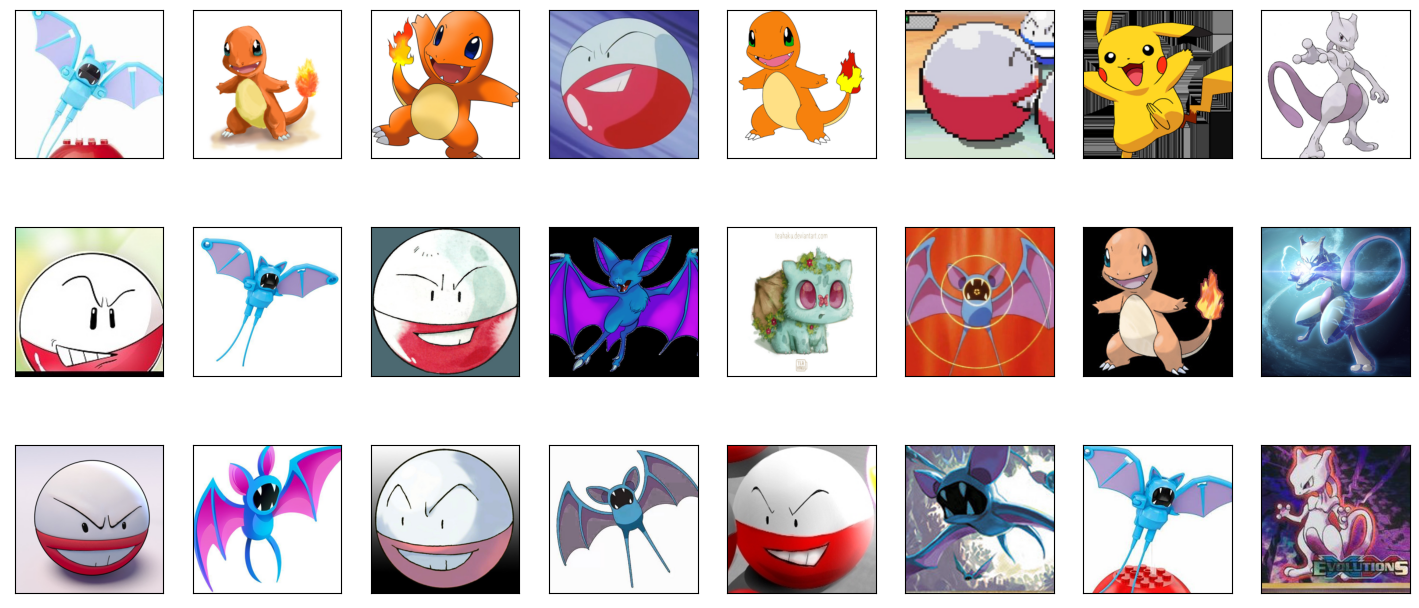

In [15]:
sample_size = 24


plotimgs = copy.deepcopy(images)
numpy.random.shuffle(plotimgs)
rows = plotimgs[:sample_size]

_, subplots = plt.subplots(nrows = math.ceil(sample_size/8), ncols = 8, figsize=(18, int(sample_size/3)))
subplots = subplots.flatten()
for i, x in enumerate(rows):
    subplots[i].imshow(numpy.reshape(x, [size, size, 3]))
    subplots[i].set_xticks([])
    subplots[i].set_yticks([])

# 🛠️ Preprocessing
Given that this case uses images, there is no such thing as feature selection because one cannot select some pixels to be better indicators than other pixels beforehand. Therefore, there is little to do in terms of preprocessing other than splitting the dataset into a trainset and testset.

🪓 Splitting into train/test

A split of 70%/30% is chosen here in order to have a fairly large number of testing images. 

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=.3, random_state=0)

# 🧬 Modelling

In this step the model will be fitted with the trainset only. In this case a [Support Vector Machine for classification](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

In [17]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.8253968253968254


# 🔬 Evaluation
Below a classification report is printed. This shows for every one of the classes how well the model performed.

In [18]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

   Bulbasaur       1.00      0.62      0.77         8
  Charmander       1.00      1.00      1.00         7
   Electrode       0.79      1.00      0.88        15
      Mewtwo       0.62      0.42      0.50        12
     Pikachu       1.00      1.00      1.00        11
       Zubat       0.69      0.90      0.78        10

    accuracy                           0.83        63
   macro avg       0.85      0.82      0.82        63
weighted avg       0.83      0.83      0.81        63



It appears that Mewtwo is fairly hard to recognize, but the others all seem well. The code below will plot every pokemon in the testset, including the predicted label as well as whether this was correct or wrong.

NameError: name 'pred' is not defined

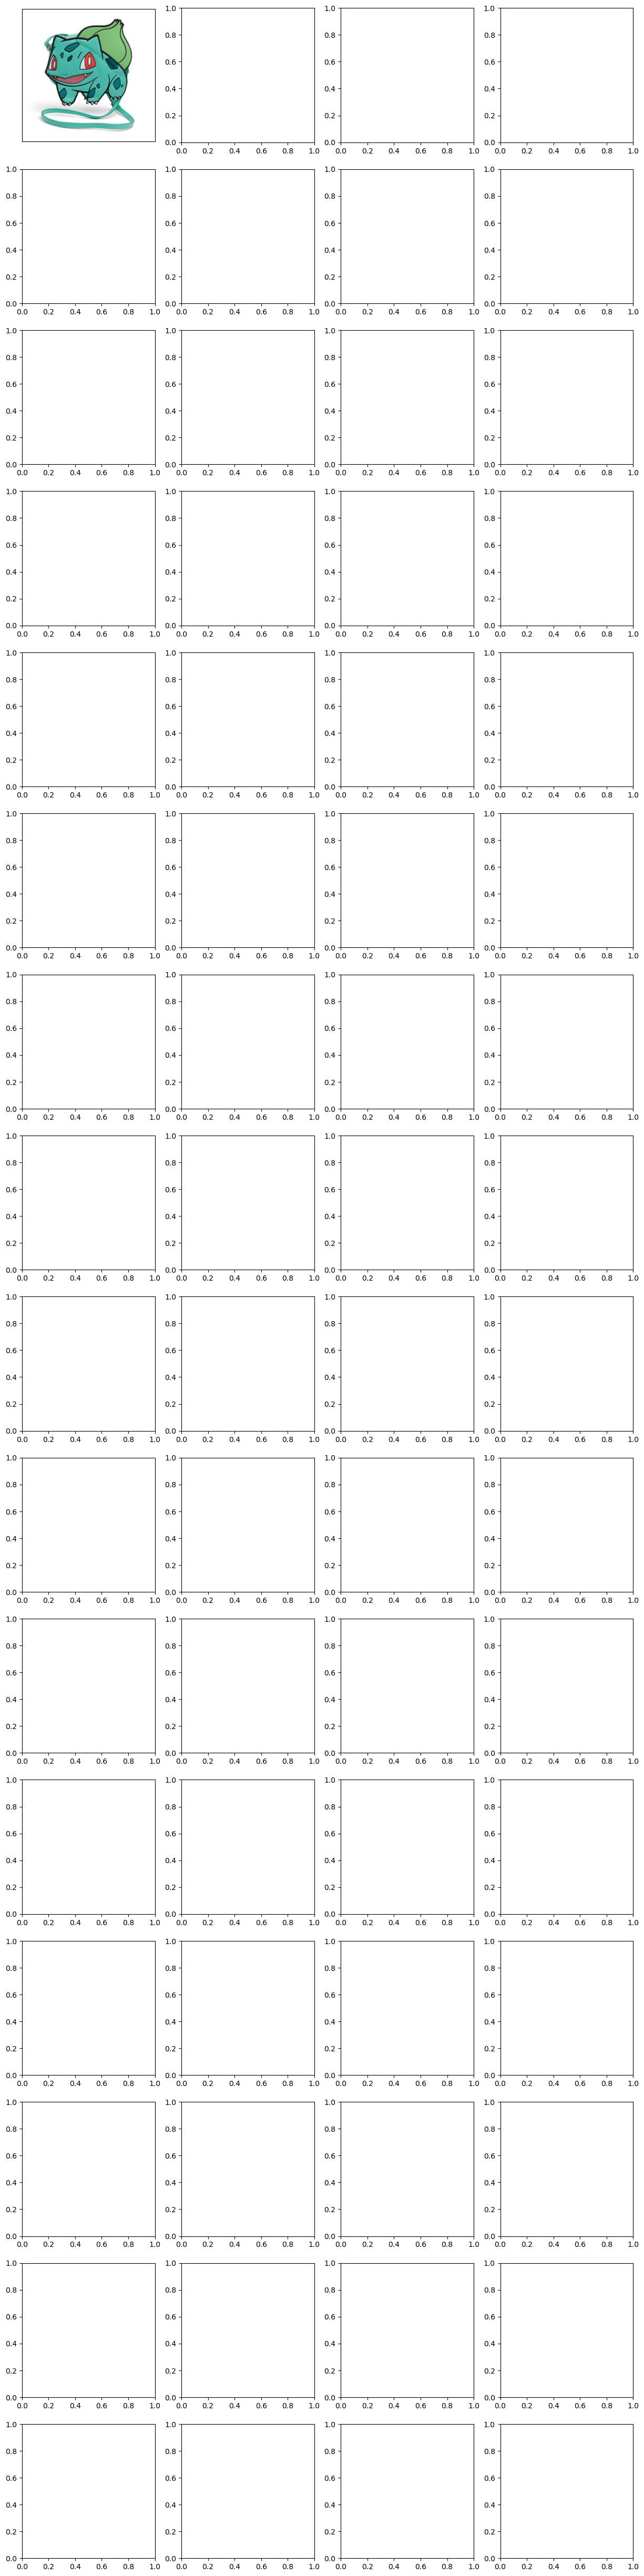

In [19]:
_, subplots = plt.subplots(nrows = math.ceil(len(X_test)/4), ncols = 4, figsize=(15, len(X_test)))
subplots = subplots.flatten()

for i, x in enumerate(X_test):
    subplots[i].imshow(numpy.reshape(x, [size, size, 3]))
    subplots[i].set_xticks([])
    subplots[i].set_yticks([])
    subplots[i].set_title(pred[i] + (" (correct)" if pred[i] == y_test[i] else " (wrong)"))

Even a relatively simple Support Vector Machine with just minutes of training time can do reasonably well at image recognition. Surely a deep learning CNN would perhaps do even better, but also at largely increased need for training resources and time. Probably, when the number of Pokemon increases and others with similar colours will be added this model's quality is likely to decrease quite rappidly, but then maybe also the quality of the images should be improved to help the machine. For example, the current images are of rather poor resolution and some even have significant background noise. Having cleaner, high quality, high resolution images may improve the general outcome.

# Hyperparameter C
The `C` is a hyperparameter that controls the trade-off between maximizing the margin and minimizing the classification error, therefore choosing a high value can lead to overfitting the model and a low one can lead to underfitting.

In [22]:
def train_SVC_model(C):
    # Modeling
    from sklearn.svm import SVC
    model = SVC(C=C)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    # Evaluation 
    from sklearn.metrics import classification_report
    predictions = model.predict(X_test)
    report = classification_report(y_test, predictions)
    print("C is " + str(C))
    print(report)

for c in [1.0,0.5,2.0]:
    train_SVC_model(c)

C is 1.0
              precision    recall  f1-score   support

   Bulbasaur       1.00      0.62      0.77         8
  Charmander       1.00      1.00      1.00         7
   Electrode       0.79      1.00      0.88        15
      Mewtwo       0.62      0.42      0.50        12
     Pikachu       1.00      1.00      1.00        11
       Zubat       0.69      0.90      0.78        10

    accuracy                           0.83        63
   macro avg       0.85      0.82      0.82        63
weighted avg       0.83      0.83      0.81        63



C:\Users\Home\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Home\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Home\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C is 0.5
              precision    recall  f1-score   support

   Bulbasaur       0.00      0.00      0.00         8
  Charmander       0.00      0.00      0.00         7
   Electrode       0.71      1.00      0.83        15
      Mewtwo       0.00      0.00      0.00        12
     Pikachu       0.61      1.00      0.76        11
       Zubat       0.42      1.00      0.59        10

    accuracy                           0.57        63
   macro avg       0.29      0.50      0.36        63
weighted avg       0.34      0.57      0.42        63

C is 2.0
              precision    recall  f1-score   support

   Bulbasaur       1.00      0.75      0.86         8
  Charmander       1.00      1.00      1.00         7
   Electrode       0.83      1.00      0.91        15
      Mewtwo       0.56      0.42      0.48        12
     Pikachu       1.00      1.00      1.00        11
       Zubat       0.67      0.80      0.73        10

    accuracy                           0.83        63
   ma

## Concluion
The first model with `C` as 1 which is the default gave good results compared to `C` as 0.5, because the penalty for misclassification as 1 is good enough for this dataset since there are no overlapping data.

The second model with `C` as 0.5 led to overfitting the model since the penalty for misclassification is too low for this dataset.

The third model with `C` as 2 is the best but isn't significantly better than the first one, because having the penalty for misclassification as 1 or 2 in this dataset doesn't show significant improvement, therefore `C` as 2 is the best from of all of them.

# Hyperparameter kernel
The kernel is a function that transforms the input data from its original feature space into a higher-dimensional feature space. The pourpose of using it, So the data can be maped into a space where the problem of finding a linearly separable boundary is easier to solve.

There are four types which are `rbf` as the defualt, `linear`, `poly`, `sigmoid` and `precomputed`, we aren't going to expertmaint `precomputed` because the execrise instraction asked not to add it. 

When to use every type of them:

The `rbf` when the decision boundary is a non-linear curve. It is very effective for a wide range of classification problems.

The `linear` when the dataset is lineraly separable and with high-dimensional datasets.

The `poly` when the dataset has non-linear features that can be transformed into higher dimensions.

The `sigmoid` when the data that has a sigmoid shape, such as in neural networks and images.

In [21]:
def train_SVC_model(kernel):
    # Modeling
    from sklearn.svm import SVC
    model = SVC(kernel=kernel)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    # Evaluation 
    from sklearn.metrics import classification_report
    predictions = model.predict(X_test)
    report = classification_report(y_test, predictions)
    print("kernel is " + kernel)
    print(report)

for kernel in ['rbf','linear','poly','sigmoid']:
    train_SVC_model(kernel)

kernel is rbf
              precision    recall  f1-score   support

   Bulbasaur       1.00      0.62      0.77         8
  Charmander       1.00      1.00      1.00         7
   Electrode       0.79      1.00      0.88        15
      Mewtwo       0.62      0.42      0.50        12
     Pikachu       1.00      1.00      1.00        11
       Zubat       0.69      0.90      0.78        10

    accuracy                           0.83        63
   macro avg       0.85      0.82      0.82        63
weighted avg       0.83      0.83      0.81        63

kernel is linear
              precision    recall  f1-score   support

   Bulbasaur       1.00      1.00      1.00         8
  Charmander       1.00      0.86      0.92         7
   Electrode       0.71      1.00      0.83        15
      Mewtwo       0.80      0.33      0.47        12
     Pikachu       0.92      1.00      0.96        11
       Zubat       0.82      0.90      0.86        10

    accuracy                           0.84   

C:\Users\Home\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Home\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Home\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Concluion
The `sigmoid` surpisingly didn't get the expected performance, due to the fact that the number of the features are too high in the image classification and the `sigmoid` function doesn't work well with high features number which leads to overfitting and increase the complexity of the model.

# Moaaahhhh Pokemon
Below you can see how adding four more classes can change the performance of the model.

In [31]:
# Data provisioning
size = 256

def load_image(file, size):
    img = Image.open(file)
    img = img.resize((size, size))
    return numpy.array(img).flatten()

def load_labelled_images(path, size):
    labels = list()
    files = list()
    for file_info in [x for x in pathlib.Path(path).glob("**/*.jpg")]:
        labels.append(file_info.parts[1])
        files.append(str(file_info))
    imgs = numpy.array([load_image(f, size) for f in files])
    return imgs, numpy.array(labels)      

images, labels = load_labelled_images("./AddingMoreFourClasses", size)
    
# Spiltting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=.3, random_state=0)

# Modeling 
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)

# Evaluation
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

   Bulbasaur       1.00      0.62      0.77         8
  Charmander       0.45      1.00      0.62         5
   Electrode       0.89      0.94      0.91        17
   Fireponey       0.00      0.00      0.00         1
      Meowth       0.00      0.00      0.00         3
      Mewtwo       0.33      0.50      0.40         8
      Pidgey       0.00      0.00      0.00         3
     Pikachu       0.90      0.75      0.82        12
     Psyduck       0.00      0.00      0.00         1
       Zubat       0.75      0.90      0.82        10

    accuracy                           0.71        68
   macro avg       0.43      0.47      0.43        68
weighted avg       0.68      0.71      0.68        68



C:\Users\Home\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Home\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Home\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Conclusion
Adding four more classes caused the recognition of the `Pikachu` decrease since we add `Meowth` which has the same color compensation. The accuracy of the model also decreases due to adding more classes that have similar color combinations which led to confusion for the model when classifying the classes.

# Your own images
At this part we have two classes and the model should distangtion the picture provided. The dataset is 50 observations.

In [42]:
# Data provisioning
size = 256

def load_image(file, size):
    img = Image.open(file)
    img = img.resize((size, size))
    return numpy.array(img).flatten()

def load_labelled_images(path, size):
    labels = list()
    files = list()
    for file_info in [x for x in pathlib.Path(path).glob("**/*.jpg")]:
        labels.append(file_info.parts[1])
        files.append(str(file_info))
    imgs = numpy.array([load_image(f, size) for f in files])
    return imgs, numpy.array(labels)      

images, labels = load_labelled_images("./ClassmatesPart", size)
    
# Spiltting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=.3, random_state=0)

# Modeling 
from sklearn.svm import SVC
model = SVC()
model.fit(X_train, y_train)

# Evaluation
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00         1
        Book       1.00      1.00      1.00        10

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



#### Students

Name: Niels Roef

## Summary

NIELS I will remove the Apple class I was just trying something, bc I need to add your class.


Did it work? Why yes/no? Is this model good? Discuss with your fellow students, write their names in the box below and write a short summary (~150 words) of your discussion and conclusions.